# Process Web Json and Find Center claims

* Load Web Json file
* Extract claims and premises (data parsing)
* Find center claims

In [1]:
import os
import json

## Load data and extract premises

In [2]:
from helper_function import count_valid_posts, get_premises
import numpy as np

with open('v3_70/Should-I-invest-in-Bitcoin_with_labels_v2_70.json', 'r') as f:
    x = json.load(f)
print(f'Load posts, (valid, all) = {count_valid_posts(x)}')

Load posts, (valid, all) = (41, 70)


In [4]:
premises = get_premises(x)
print(f"get {len(premises)} premises")
# premises

get 88 premises


## Get center premises

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [6]:
# Load model from huggingface hub
tokenizer = AutoTokenizer.from_pretrained('pretrained_models/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('pretrained_models/all-MiniLM-L6-v2')


In [9]:
encoded_input = tokenizer(premises, padding=True, truncation=True, return_tensors='pt')
with torch.no_grad():
    model_output = model(**encoded_input)
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
#Normaliation
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1).numpy()
sentence_embeddings = np.array(sentence_embeddings)
sentence_embeddings.shape

(88, 384)

Explained variance =  0.17477325


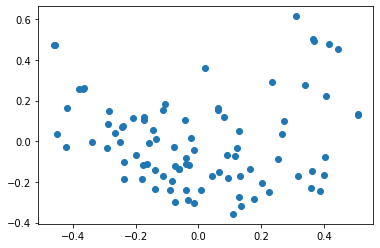

In [12]:
## Demension reduction with PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation

## Visualization
pca = PCA(n_components=2)
x_pca = pca.fit_transform(sentence_embeddings)
print("Explained variance = ", np.sum(pca.explained_variance_ratio_))
plt.scatter(x_pca.T[0], x_pca.T[1])
plt.show()

In [11]:
# demension redunction -- serves as denoising

pca = PCA()
sentence_embeddings_distilled = pca.fit_transform(sentence_embeddings)

In [13]:
# clustering
cluster_algo = AffinityPropagation(random_state=43)

cluster = cluster_algo.fit(sentence_embeddings_distilled)
print("Clustered into {} clusters with labels {}".format(
    np.unique(cluster.labels_).shape, np.unique(cluster.labels_)))

# print the clustering distribtion
print(dict(zip(*np.unique(cluster.labels_, return_counts=True))))


Clustered into (20,) clusters with labels [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
{0: 1, 1: 9, 2: 2, 3: 4, 4: 2, 5: 2, 6: 3, 7: 1, 8: 5, 9: 18, 10: 10, 11: 14, 12: 7, 13: 2, 14: 1, 15: 3, 16: 1, 17: 1, 18: 1, 19: 1}


In [14]:
premises_clusters = {i:[] for i in range(len(np.unique(cluster.labels_)))}

for i, label in enumerate(cluster.labels_):
    premises_clusters[label].append(premises[i])

premises_clusters

{0: ['You’re less worried about whether it’s “too late” or “is now a good time” and focused on doing your research and understanding what you’re buying. This phrase sums it up better than I could.'],
 1: ['Bitcoin is like digital gold. Just like gold has value because it is scarce, so does bitcoin, the digital store of value that can be sent around the world instantly, securely and for free.',
  'The internet made information global and easy to access. A sound, global currency like Bitcoin will have the same impact on finance and the global economy.',
  'Limited use. Bitcoin is currently only accepted by few online merchants. Many companies don’t also recognize bitcoin as a legitimate exchange, making it an unfeasible investment vessel. Besides, there’s only a fixed supply of bitcoin — 21 million.',
  'Bitcoin is pretty useless. But so is gold.',
  'The bitcoin protocol provides the most secure system to make online payments and with so many payment processing system creating products 

In [15]:
for i, term in enumerate(cluster.cluster_centers_indices_):
    print(f"{i}: \t {premises[term]}")

0: 	 You’re less worried about whether it’s “too late” or “is now a good time” and focused on doing your research and understanding what you’re buying. This phrase sums it up better than I could.
1: 	 Bitcoin is like digital gold. Just like gold has value because it is scarce, so does bitcoin, the digital store of value that can be sent around the world instantly, securely and for free.
2: 	 Bitcoins can be sent from anywhere in the world to anywhere else in the world. No bank can block payments or close your account. Bitcoin is censorship resistant money.
3: 	 Bitcoin’s monetary policy is one of its most important features. It’s possible to see when new bitcoins are created, when a transaction is created, or how many bitcoins are in circulation.
4: 	 Little or no regulation. The bitcoin market currently operates with no major regulations. It isn’t taxed and governments have no clear stance on it. As a result, you could stand exposed to fraud and malpractice.
5: 	 Wallets can be lost. 